## Steps
Perform exploratory  Data Analysis and determine Training Labels

*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data

*   Use the feature engineered dataset and apply the best model found for the previous step to see if Accuracy of prediction increases or not.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

## Import dataset

In [2]:
df = pd.read_csv('Wrangled_data.csv')
df.drop(['Outcome'], axis=1, inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Landing_Outcome,Landing_Region
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,NaN,1,0,B0003,-80.577366,28.561857,0,None
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,1,False,False,False,NaN,1,0,B0005,-80.577366,28.561857,0,None
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,1,False,False,False,NaN,1,0,B0007,-80.577366,28.561857,0,None
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1,0,B1003,-120.610829,34.632093,0,Ocean
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,NaN,1,0,B1004,-80.577366,28.561857,0,None


Let's drop unnecessary columns such as 
Serial, Outcome, Flight Number

In [3]:
df.drop(['Serial','Date','BoosterVersion','Longitude','Latitude'], axis = 1, inplace=True)

In [4]:
df.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Landing_Outcome,Landing_Region
0,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,NaN,1,0,0,None
1,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,NaN,1,0,0,None
2,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,NaN,1,0,0,None
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1,0,0,Ocean
4,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,NaN,1,0,0,None


In [5]:
df["LandingPad"].unique()

array([nan, '5e9e3032383ecb761634e7cb', '5e9e3032383ecb6bb234e7ca',
       '5e9e3032383ecb267a34e7c7', '5e9e3033383ecbb9e534e7cc',
       '5e9e3032383ecb554034e7c9'], dtype=object)

In [6]:
df['LandingPad'].fillna('None', inplace=True)

In [7]:
LandingPadno = 0
for padid in df["LandingPad"].unique():
    if padid == "None":
        df["LandingPad"].replace("None", "NoLandingPad", inplace=True)
    else:
        df["LandingPad"].replace(padid, f"LandingPad{LandingPadno}", inplace=True)
        
    LandingPadno += 1
del LandingPadno

In [8]:
df['LandingPad'].value_counts()

LandingPad2     35
NoLandingPad    26
LandingPad3     13
LandingPad4     12
LandingPad1      2
LandingPad5      2
Name: LandingPad, dtype: int64

Let's do 'One-hot Encoding' to get dummy variables

In [9]:
X = df.drop(['Landing_Outcome'], axis = 1)
X.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Landing_Region
0,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,NoLandingPad,1,0,None
1,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,NoLandingPad,1,0,None
2,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,NoLandingPad,1,0,None
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NoLandingPad,1,0,Ocean
4,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,NoLandingPad,1,0,None


In [10]:
Y = df['Landing_Outcome'].to_numpy()
Y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

Let's look at the data type of the columns first!

In [11]:
X.dtypes

FlightNumber        int64
PayloadMass       float64
Orbit              object
LaunchSite         object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block               int64
ReusedCount         int64
Landing_Region     object
dtype: object

##### Firstly, let's work on the columns with string data type

In [12]:
def dummies(X, column_names):
    for icol in column_names:
        dummy = pd.get_dummies(X[icol])
        X = X.join(dummy)
    return X

In [13]:
dummy_columns_str = ['Orbit','LaunchSite','LandingPad','Landing_Region']
X = dummies(X, column_names= dummy_columns_str)
X

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,...,LandingPad1,LandingPad2,LandingPad3,LandingPad4,LandingPad5,NoLandingPad,ASDS,None,Ocean,RTLS
0,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,NoLandingPad,1,...,0,0,0,0,0,1,0,1,0,0
1,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,NoLandingPad,1,...,0,0,0,0,0,1,0,1,0,0
2,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,NoLandingPad,1,...,0,0,0,0,0,1,0,1,0,0
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NoLandingPad,1,...,0,0,0,0,0,1,0,0,1,0
4,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,NoLandingPad,1,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,15600.000000,VLEO,KSC LC 39A,2,True,True,True,LandingPad2,5,...,0,1,0,0,0,0,1,0,0,0
86,87,15600.000000,VLEO,KSC LC 39A,3,True,True,True,LandingPad2,5,...,0,1,0,0,0,0,1,0,0,0
87,88,15600.000000,VLEO,KSC LC 39A,6,True,True,True,LandingPad2,5,...,0,1,0,0,0,0,1,0,0,0
88,89,15600.000000,VLEO,CCSFS SLC 40,3,True,True,True,LandingPad4,5,...,0,0,0,1,0,0,1,0,0,0


Let's Convert the booleans into string first and then repeat the same process

In [14]:
X['Legs'] = X['Legs'].map({True: 'True', False: 'False'})
X['Reused'] = X['Reused'].map({True: 'True', False: 'False'})
X['GridFins'] = X['GridFins'].map({True: 'True', False: 'False'})

In [15]:
X.dtypes

FlightNumber        int64
PayloadMass       float64
Orbit              object
LaunchSite         object
Flights             int64
GridFins           object
Reused             object
Legs               object
LandingPad         object
Block               int64
ReusedCount         int64
Landing_Region     object
ES-L1               uint8
GEO                 uint8
GTO                 uint8
HEO                 uint8
ISS                 uint8
LEO                 uint8
MEO                 uint8
PO                  uint8
SO                  uint8
SSO                 uint8
VLEO                uint8
CCSFS SLC 40        uint8
KSC LC 39A          uint8
VAFB SLC 4E         uint8
LandingPad1         uint8
LandingPad2         uint8
LandingPad3         uint8
LandingPad4         uint8
LandingPad5         uint8
NoLandingPad        uint8
ASDS                uint8
None                uint8
Ocean               uint8
RTLS                uint8
dtype: object

In [16]:
def dummies_bool(X, column_names):
    for icol in column_names:
        dummy_bool = pd.get_dummies(X[icol], prefix= icol, prefix_sep= '_', )
        X = X.join(dummy_bool)
    return X

In [17]:
dummy_columns_bool = ['Legs','GridFins','Reused']
X = dummies_bool(X, column_names= dummy_columns_bool)
X

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,...,ASDS,None,Ocean,RTLS,Legs_False,Legs_True,GridFins_False,GridFins_True,Reused_False,Reused_True
0,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,NoLandingPad,1,...,0,1,0,0,1,0,1,0,1,0
1,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,NoLandingPad,1,...,0,1,0,0,1,0,1,0,1,0
2,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,NoLandingPad,1,...,0,1,0,0,1,0,1,0,1,0
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NoLandingPad,1,...,0,0,1,0,1,0,1,0,1,0
4,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,NoLandingPad,1,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,15600.000000,VLEO,KSC LC 39A,2,True,True,True,LandingPad2,5,...,1,0,0,0,0,1,0,1,0,1
86,87,15600.000000,VLEO,KSC LC 39A,3,True,True,True,LandingPad2,5,...,1,0,0,0,0,1,0,1,0,1
87,88,15600.000000,VLEO,KSC LC 39A,6,True,True,True,LandingPad2,5,...,1,0,0,0,0,1,0,1,0,1
88,89,15600.000000,VLEO,CCSFS SLC 40,3,True,True,True,LandingPad4,5,...,1,0,0,0,0,1,0,1,0,1


In [18]:
X.columns

Index(['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights',
       'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount',
       'Landing_Region', 'ES-L1', 'GEO', 'GTO', 'HEO', 'ISS', 'LEO', 'MEO',
       'PO', 'SO', 'SSO', 'VLEO', 'CCSFS SLC 40', 'KSC LC 39A', 'VAFB SLC 4E',
       'LandingPad1', 'LandingPad2', 'LandingPad3', 'LandingPad4',
       'LandingPad5', 'NoLandingPad', 'ASDS', 'None', 'Ocean', 'RTLS',
       'Legs_False', 'Legs_True', 'GridFins_False', 'GridFins_True',
       'Reused_False', 'Reused_True'],
      dtype='object')

In [19]:
X = X.drop(['Orbit','LaunchSite','LandingPad','Reused','Legs','GridFins','Landing_Region'], axis=1)
X

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,ES-L1,GEO,GTO,HEO,ISS,...,ASDS,None,Ocean,RTLS,Legs_False,Legs_True,GridFins_False,GridFins_True,Reused_False,Reused_True
0,1,6123.547647,1,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0
1,2,525.000000,1,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0
2,3,677.000000,1,1,0,0,0,0,0,1,...,0,1,0,0,1,0,1,0,1,0
3,4,500.000000,1,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,1,0
4,5,3170.000000,1,1,0,0,0,1,0,0,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,15600.000000,2,5,12,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,1
86,87,15600.000000,3,5,13,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,1
87,88,15600.000000,6,5,12,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,1
88,89,15600.000000,3,5,12,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,1


Standardize the X

In [20]:
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [22]:
X_train.shape, X_test.shape

((72, 35), (18, 35))

In [23]:
Y_train.shape, Y_test.shape

((72,), (18,))

## Buidling and Training Model

This is a classification problem. So, naturally we would be exploring the classfication algorithms for better accuracy of a model.

* Logistic Regression

* Support Vector Machine (SVM)

* Decission Tree Classifier

* K-Nearest Neighbour (KNN)

### Firstly, let's create the confusion matrix function to display of results of each model

In [24]:
def plot_confusion_matrix(y, y_hat):
    cm = confusion_matrix(y, y_hat)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'landed'])
    ax.yaxis.set_ticklabels(['did not land', 'landed'])

# Logistic Regression

We will create a logistic regression object >>>  a GridSearchCV object  <code>logreg_cv</code> with cv = 10. 

 Fit the object to find the best parameters from the dictionary <code>parameters_lr</code>.

In [25]:
parameters_lr ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}

lr = LogisticRegression(random_state=12345)

# define the grid search object
gridsearch_lr = GridSearchCV(
    estimator = lr, 
    param_grid = parameters_lr,
    scoring= 'accuracy', 
    cv = 10
    )

#execute search
logreg_cv = gridsearch_lr.fit(X_train,Y_train)

In [26]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8767857142857143


In [27]:
print('Accuracy on test data is: {:.3f}'.format(logreg_cv.score(X_test, Y_test)))

Accuracy on test data is: 0.833


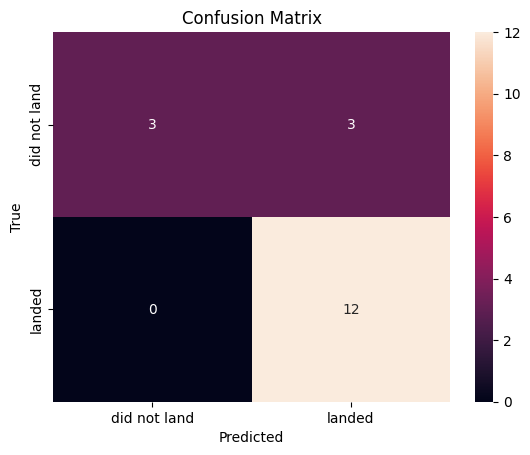

In [28]:
yhat = logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [29]:
lr_accuracy = accuracy_score(yhat, Y_test)
lr_precision = precision_score(yhat, Y_test)
lr_recall = recall_score(yhat, Y_test)
lr_f1 = f1_score(yhat, Y_test)

print(" The overall accuracy of the model with different modules are given below: \n Accuracy: %.2f \n Precision: %.2f \n Recall: %.2f \n f1_score: %.2f" % (lr_accuracy, lr_precision, lr_recall, lr_f1))

 The overall accuracy of the model with different modules are given below: 
 Accuracy: 0.83 
 Precision: 1.00 
 Recall: 0.80 
 f1_score: 0.89


### Support Vector Machine

In [30]:
parameters_svm = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}

svm = SVC(random_state = 12345)

# define the grid search object
gridsearch_svm = GridSearchCV(
    estimator = svm, 
    param_grid = parameters_svm,
    scoring= 'accuracy', 
    cv = 10
    )

#execute search
svm_cv = gridsearch_svm.fit(X_train,Y_train)

In [31]:
print("Tuned hpyerparameters :(best parameters) \n ",svm_cv.best_params_)
print("Accuracy :",svm_cv.best_score_)

Tuned hpyerparameters :(best parameters) 
  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
Accuracy : 0.9035714285714287


In [32]:
print('Accuracy on test data is: {:.3f}'.format(svm_cv.score(X_test, Y_test)))

Accuracy on test data is: 0.778


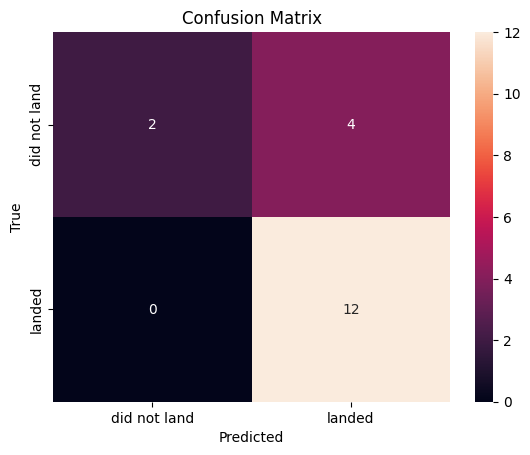

In [33]:
yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [34]:
svm_accuracy = accuracy_score(yhat, Y_test)
svm_precision = precision_score(yhat, Y_test)
svm_recall = recall_score(yhat, Y_test)
svm_f1 = f1_score(yhat, Y_test)

print(" The overall accuracy of the SVM model with different modules are given below: \n Accuracy: %.2f \n Precision: %.2f \n Recall: %.2f \n f1_score: %.2f" % (svm_accuracy, svm_precision, svm_recall, svm_f1))

 The overall accuracy of the SVM model with different modules are given below: 
 Accuracy: 0.78 
 Precision: 1.00 
 Recall: 0.75 
 f1_score: 0.86


### Decision Tree Classifier

In [35]:
parameters_tree = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier(random_state = 12345)

# define the grid search object
gridsearch_tree = GridSearchCV(
    estimator = tree,
    param_grid = parameters_tree,
    scoring = 'accuracy',
    cv = 10
)
# execute search
tree_cv = gridsearch_tree.fit(X_train, Y_train)

C:\Users\Jami\AppData\Roaming\Python\Python39\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\Jami\AppData\Roaming\Python\Python39\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\Jami\AppData\Roaming\Python\Python39\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\Jami\AppData\Roaming\Python\Python39\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behavi

In [36]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.9142857142857143


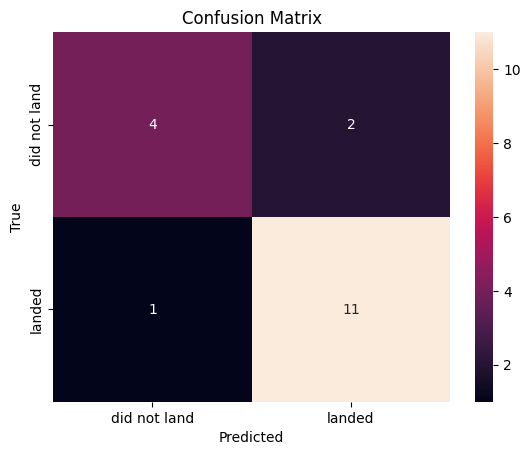

In [37]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [38]:
tree_accuracy = accuracy_score(yhat, Y_test)
tree_precision = precision_score(yhat, Y_test)
tree_recall = recall_score(yhat, Y_test)
tree_f1 = f1_score(yhat, Y_test)

print(" The overall accuracy of the Decision Tree model with different modules are given below: \n Accuracy: %.2f \n Precision: %.2f \n Recall: %.2f \n f1_score: %.2f" % (tree_accuracy, tree_precision, tree_recall, tree_f1))

 The overall accuracy of the Decision Tree model with different modules are given below: 
 Accuracy: 0.83 
 Precision: 0.92 
 Recall: 0.85 
 f1_score: 0.88


### KNN-K Nearest Neighbours

In [39]:
parameters_knn = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

knn = KNeighborsClassifier()

grid_search_knn = GridSearchCV(
    estimator = knn,
    param_grid = parameters_knn,
    scoring = 'accuracy',
    cv = 10
)
# execute search
knn_cv = grid_search_knn.fit(X_train, Y_train)

In [40]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 5, 'p': 2}
accuracy : 0.8767857142857143


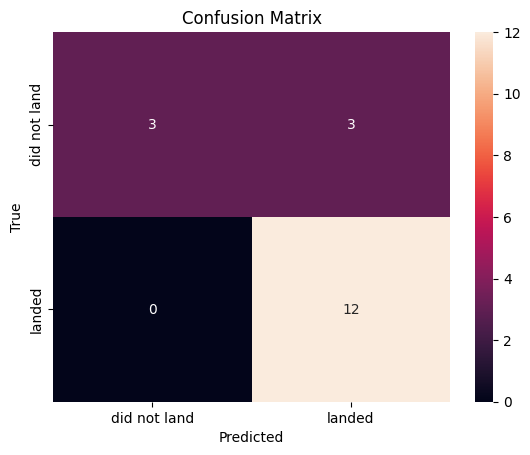

In [41]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [42]:
knn_accuracy = accuracy_score(yhat, Y_test)
knn_precision = precision_score(yhat, Y_test)
knn_recall = recall_score(yhat, Y_test)
knn_f1 = f1_score(yhat, Y_test)

print(" The overall accuracy of the KNN model with different modules are given below: \n Accuracy: %.2f \n Precision: %.2f \n Recall: %.2f \n f1_score: %.2f" % (knn_accuracy, knn_precision, knn_recall, knn_f1))

 The overall accuracy of the KNN model with different modules are given below: 
 Accuracy: 0.83 
 Precision: 1.00 
 Recall: 0.80 
 f1_score: 0.89


### Let's find the best model

In [43]:
models = {
    'LogisticRegression':logreg_cv.best_score_, 
    'SupportVector': svm_cv.best_score_,
    'DecisionTree':tree_cv.best_score_,
    'KNeighbors':knn_cv.best_score_
}
models

{'LogisticRegression': 0.8767857142857143,
 'SupportVector': 0.9035714285714287,
 'DecisionTree': 0.9142857142857143,
 'KNeighbors': 0.8767857142857143}

In [44]:
BestModel = max(models, key=models.get)

if BestModel == 'DecisionTree':
    print('Best model is Decision Tree with a score of:', models[BestModel], "\n" "The best parameters are:\n", tree_cv.best_params_ )

if BestModel == 'KNeighbors':
    print('Best model is KNN with a score of:', models[BestModel], "\n" "The best parameters are:\n", knn_cv.best_params_ )

if BestModel == 'LogisticRegression':
    print('Best model is LogisticRegression with a score of:', models[BestModel], "\n" "The best parameters are:\n", logreg_cv.best_params_)

if BestModel == 'SupportVector':
    print('Best model is SupportVector with a score of:', models[BestModel], "\n" "The best parameters are:\n", svm_cv.best_params_)


Best model is Decision Tree with a score of: 0.9142857142857143 
The best parameters are:
 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}


#### The Decision Tree Classifier showcases the best result for the dataset.

Now, there are multiple features in the dataset that do not have any correlation with the target- Landing_Outcome! Also, some variables are strongly correlated to each other, which increases the possibility Overfitting of the model. We can observe comparatively low test set accuracy for every model.

So, I will try to improve the model accuracy by building a decision tree classifier model which is trained on the dataset which was 'Feature Engineered'. 

The feature engineered dataset had comparatively fewer variables. To be specific- I found out that only these following variables that are independent from each other and have strong correlation with the target variable.

*Legs

*Orbit

*Landing_Region

*Block

Let's see if I can improve model accuracy from 91.43% !!!!!

In [45]:
feature_df = pd.read_csv('Feature_set.csv')
feature_df.head(10)

,Legs,Block,Landing_Outcome,ES-L1,GEO,GTO,HEO,ISS,LEO,MEO,PO,SO,SSO,VLEO,ASDS,None,Ocean,RTLS
0,False,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,False,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,False,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,False,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,False,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
5,False,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
6,True,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
7,True,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
8,False,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
9,False,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [46]:
feature_df['Legs'] = feature_df['Legs'].map({True: 'True', False: 'False'})

In [47]:
dummy = pd.get_dummies(feature_df['Legs'], prefix= 'Legs', prefix_sep= '_', )
feature_df = feature_df.join(dummy)
feature_df.head()


,Legs,Block,Landing_Outcome,ES-L1,GEO,GTO,HEO,ISS,LEO,MEO,PO,SO,SSO,VLEO,ASDS,None,Ocean,RTLS,Legs_False,Legs_True
0,False,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
1,False,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
2,False,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
3,False,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
4,False,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [48]:
feature_df = feature_df.drop('Legs', axis = 1)
feature_df.head()

,Block,Landing_Outcome,ES-L1,GEO,GTO,HEO,ISS,LEO,MEO,PO,SO,SSO,VLEO,ASDS,None,Ocean,RTLS,Legs_False,Legs_True
0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
3,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [49]:
X = feature_df.drop('Landing_Outcome', axis = 1)
X.head()

,Block,ES-L1,GEO,GTO,HEO,ISS,LEO,MEO,PO,SO,SSO,VLEO,ASDS,None,Ocean,RTLS,Legs_False,Legs_True
0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
2,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
4,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [50]:
Y = feature_df['Landing_Outcome']
Y

0     0
1     0
2     0
3     0
4     0
     ..
85    1
86    1
87    1
88    1
89    1
Name: Landing_Outcome, Length: 90, dtype: int64

In [51]:
transform_new = preprocessing.StandardScaler()
X = transform_new.fit_transform(X)

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [53]:
parameters_tree = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree_ft = DecisionTreeClassifier(random_state = 12345)

# define the grid search object
gridsearch_tree_ft = GridSearchCV(
    estimator = tree_ft,
    param_grid = parameters_tree,
    scoring = 'accuracy',
    cv = 10
)
# execute search
tree_ft_cv = gridsearch_tree_ft.fit(X_train, Y_train)

C:\Users\Jami\AppData\Roaming\Python\Python39\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\Jami\AppData\Roaming\Python\Python39\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\Jami\AppData\Roaming\Python\Python39\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\Jami\AppData\Roaming\Python\Python39\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behavi

In [54]:
print("tuned hpyerparameters :(best parameters) ",tree_ft_cv.best_params_)
print("accuracy :",tree_ft_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}
accuracy : 0.9464285714285715


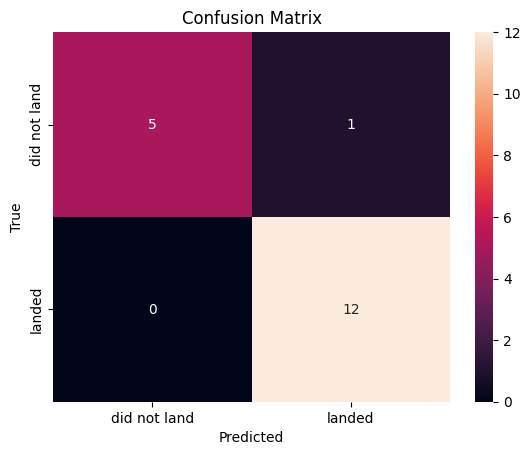

In [55]:
yhat_ft = tree_ft_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat_ft)

In [56]:
tree_ft_accuracy = accuracy_score(yhat_ft, Y_test)
tree_ft_precision = precision_score(yhat_ft, Y_test)
tree_ft_recall = recall_score(yhat_ft, Y_test)
tree_ft_f1 = f1_score(yhat_ft, Y_test)

print(" The overall accuracy of the Decision Tree model with different modules are given below: \n Accuracy: %.2f \n Precision: %.2f \n Recall: %.2f \n f1_score: %.2f" % (tree_ft_accuracy, tree_ft_precision, tree_ft_recall, tree_ft_f1))

 The overall accuracy of the Decision Tree model with different modules are given below: 
 Accuracy: 0.94 
 Precision: 1.00 
 Recall: 0.92 
 f1_score: 0.96


As we can see different sets of model accuracy is:

<code> Precision 100%, Recall 92%, f1_score of 96% and accuracy of 94% </code>!!!

That means the accuarcy has increased by more than 3%!!!

The decision tree classifier model can now predict if the landiing of a Falcon9 rocket will be successful or not with a staggering 
# <code> 94% <code/>accuracy!!